In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16267312959168182742
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15134713447
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10515524334591469198
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [2]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv('./train.csv')
print("size of train_df:", len(train_df))

# 데이터 노이즈 수정
train_df.loc[train_df['id'] == 3896, 'artist'] = 'Titian'
train_df.loc[train_df['id'] == 3986, 'artist'] = 'Alfred Sisley'

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    validation_split=0.10
) # Train / Validation

# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="training"
)

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="validation"
)

length of train_df: 5911
Found 5320 validated image filenames belonging to 50 classes.
Found 591 validated image filenames belonging to 50 classes.


In [7]:
# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3), pooling=None, input_tensor=None)

# 새로운 Fully Connected Layer 추가
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x) # 드롭아웃 추가
predictions = Dense(50, activation='softmax')(x)

#전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)


# 모델 컴파일
model.compile(optimizer=Adam(lr=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [9]:
# 모델 학습
history = model.fit(TRAIN_GENERATOR,
                    epochs=10,
                    validation_data=VALID_GENERATOR,
                    callbacks=([early_stopping])
)

Train for 167 steps, validate for 19 steps
Epoch 1/10
167/167 [==============================] - 141s 841ms/step - loss: 3.8572 - accuracy: 0.3130 - val_loss: 37.9923 - val_accuracy: 0.0271
Epoch 2/10
167/167 [==============================] - 127s 763ms/step - loss: 1.7963 - accuracy: 0.5312 - val_loss: 40.1633 - val_accuracy: 0.0152
Epoch 3/10
167/167 [==============================] - 129s 771ms/step - loss: 1.5323 - accuracy: 0.5842 - val_loss: 9.9701 - val_accuracy: 0.0085
Epoch 4/10
167/167 [==============================] - 128s 764ms/step - loss: 1.3095 - accuracy: 0.6397 - val_loss: 11.3552 - val_accuracy: 0.0220
Epoch 5/10
167/167 [==============================] - 127s 762ms/step - loss: 1.2705 - accuracy: 0.6494 - val_loss: 8.8224 - val_accuracy: 0.0626
Epoch 6/10
167/167 [==============================] - 127s 758ms/step - loss: 1.1280 - accuracy: 0.6876 - val_loss: 7.2745 - val_accuracy: 0.1844
Epoch 7/10
167/167 [==============================] - 127s 759ms/step - loss: 

In [10]:
# Validation 데이터에 대한 정확도 확인
val_loss, val_accuracy = model.evaluate(VALID_GENERATOR)
print('Validation Loss:', round(val_loss, 6))
print('Validation Accuracy:', round(val_accuracy, 3))

19/19 [==============================] - 10s 513ms/step - loss: 4.1671 - accuracy: 0.3706
Validation Loss: 4.167143
Validation Accuracy: 0.371


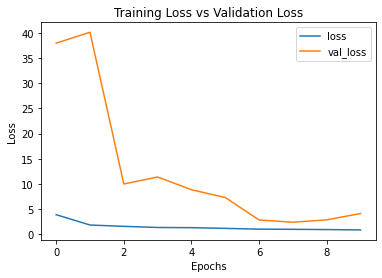

In [17]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

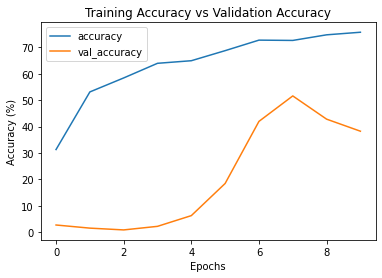

In [18]:
# 정확도 그래프
plt.plot([x * 100 for x in history.history['accuracy']])
plt.plot([x * 100 for x in history.history['val_accuracy']])
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [19]:
test_df = pd.read_csv('test.csv')

TEST_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',
    y_col='id',
    target_size=(244, 244),
    class_mode='raw',
    batch_size=32,
    shuffle=False,
)

TEST_GENERATOR.reset()

test_prediction = model.predict(TEST_GENERATOR, verbose=1)
display(test_prediction)

Found 12670 validated image filenames.
396/396 [==============================] - 411s 1s/step


array([[3.64030420e-05, 7.70450606e-06, 1.07290813e-04, ...,
        4.49395848e-05, 1.98686100e-03, 2.19479989e-06],
       [3.13749638e-06, 7.72896840e-08, 1.80107946e-07, ...,
        4.77993023e-09, 1.49814878e-06, 1.65729723e-08],
       [1.46449571e-13, 2.93151381e-13, 3.23644648e-13, ...,
        5.62930128e-12, 2.02394476e-10, 1.07638446e-13],
       ...,
       [1.82071790e-06, 1.24729652e-07, 9.27697460e-04, ...,
        4.27614441e-06, 1.04986990e-04, 2.19860567e-07],
       [2.74254663e-08, 4.18285540e-09, 3.54999558e-10, ...,
        3.81204686e-11, 1.24394120e-07, 2.76063977e-10],
       [2.87429066e-05, 3.49275433e-06, 1.40638906e-04, ...,
        3.07540060e-04, 7.92263541e-03, 1.97452982e-06]], dtype=float32)

In [47]:
test_prediction = np.argmax(test_prediction, axis = 1)
test_prediction

array([43, 43,  6, ..., 43, 43, 22], dtype=int64)

In [48]:
test_prediction_df = pd.DataFrame(test_prediction, columns = ['artist'])
test_prediction_df

,artist
0,43
1,43
2,6
3,43
4,43
...,...
12665,43
12666,43
12667,43
12668,43


In [49]:
artist_info = pd.read_csv("./artists_info.csv")
new_df = pd.DataFrame(artist_info['name'])
new_df['num'] = np.arange(50)
new_df.head()

,name,num
0,Amedeo Modigliani,0
1,Vasiliy Kandinskiy,1
2,Diego Rivera,2
3,Claude Monet,3
4,Rene Magritte,4


In [50]:
test_prediction_dic = test_prediction_df.to_dict()
test_prediction_values = test_prediction_dic['artist'].values()
test_prediction_list = list(test_prediction_values)
test_prediction_list[:5]

[43, 43, 6, 43, 43]

In [51]:
artist_info_dic = artist_info['name'].to_dict()
artist_info_dic

{0: 'Amedeo Modigliani',
 1: 'Vasiliy Kandinskiy',
 2: 'Diego Rivera',
 3: 'Claude Monet',
 4: 'Rene Magritte',
 5: 'Salvador Dali',
 6: 'Edouard Manet',
 7: 'Andrei Rublev',
 8: 'Vincent van Gogh',
 9: 'Gustav Klimt',
 10: 'Hieronymus Bosch',
 11: 'Kazimir Malevich',
 12: 'Mikhail Vrubel',
 13: 'Pablo Picasso',
 14: 'Peter Paul Rubens',
 15: 'Pierre-Auguste Renoir',
 16: 'Francisco Goya',
 17: 'Frida Kahlo',
 18: 'El Greco',
 19: 'Albrecht Dürer',
 20: 'Alfred Sisley',
 21: 'Pieter Bruegel',
 22: 'Marc Chagall',
 23: 'Giotto di Bondone',
 24: 'Sandro Botticelli',
 25: 'Caravaggio',
 26: 'Leonardo da Vinci',
 27: 'Diego Velazquez',
 28: 'Henri Matisse',
 29: 'Jan van Eyck',
 30: 'Edgar Degas',
 31: 'Rembrandt',
 32: 'Titian',
 33: 'Henri de Toulouse-Lautrec',
 34: 'Gustave Courbet',
 35: 'Camille Pissarro',
 36: 'William Turner',
 37: 'Edvard Munch',
 38: 'Paul Cezanne',
 39: 'Eugene Delacroix',
 40: 'Henri Rousseau',
 41: 'Georges Seurat',
 42: 'Paul Klee',
 43: 'Piet Mondrian',
 44: 

In [52]:
artist_name = []
for i in test_prediction_list:
    artist_name.append(artist_info_dic[i])
artist_name[:5]

['Piet Mondrian',
 'Piet Mondrian',
 'Edouard Manet',
 'Piet Mondrian',
 'Piet Mondrian']

In [53]:
submission_df = pd.read_csv("./sample_submission.csv")
submission_df = submission_df.drop('artist', axis=1)
submission_df.head()

,id
0,TEST_00000
1,TEST_00001
2,TEST_00002
3,TEST_00003
4,TEST_00004


In [54]:
submission_df['artist'] = artist_name
submission_df.head()

,id,artist
0,TEST_00000,Piet Mondrian
1,TEST_00001,Piet Mondrian
2,TEST_00002,Edouard Manet
3,TEST_00003,Piet Mondrian
4,TEST_00004,Piet Mondrian


In [55]:
submission_df.to_csv("resnet50_submission.csv", index=False)